In [1]:
import pandas as pd
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import inspect
import time
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
import pickle

In [2]:
# Read data into data frame
osho = pd.read_csv("IPG2211A2N.csv")
osho.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        1030 non-null   object 
 1   IPG2211A2N  1030 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.2+ KB


In [3]:
# Set timestamp as the index
osho['DATE'] = pd.to_datetime(osho['DATE'])
osho = osho.set_index("DATE")

# View the dataframe
osho.tail()

,IPG2211A2N
DATE,
2024-06-01,109.1424
2024-07-01,120.0882
2024-08-01,118.4131
2024-09-01,104.6917
2024-10-01,96.2642


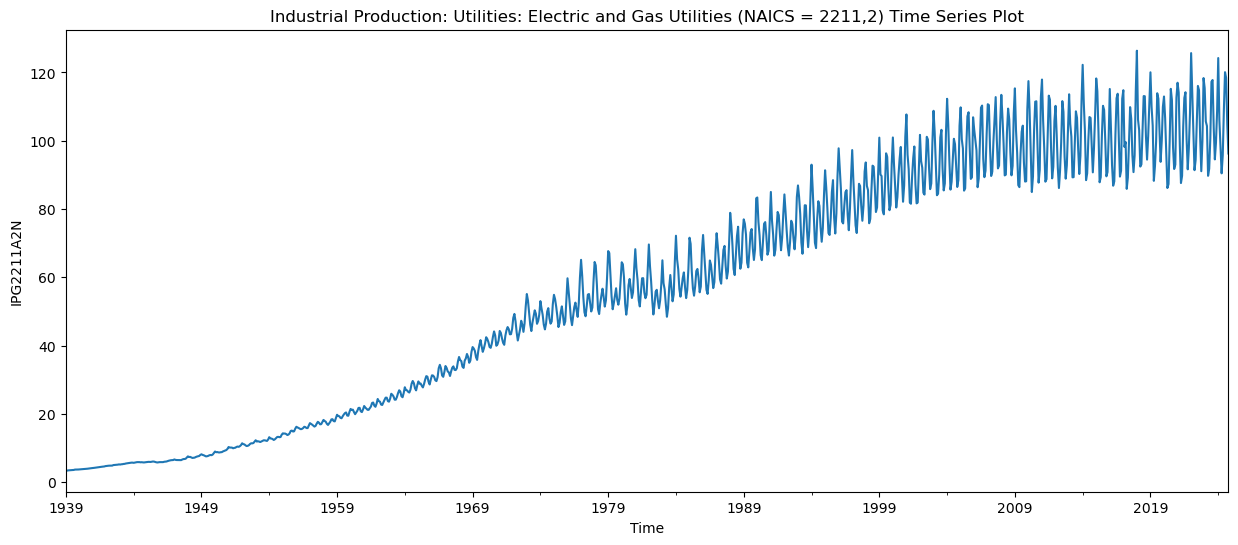

In [4]:
# Time series plot of the PM2.5 values
fig, ax = plt.subplots(figsize = (15, 6))
osho["IPG2211A2N"].plot(
    xlabel = "Time",
    ylabel = "IPG2211A2N",
    title = "Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2) Time Series Plot",
    ax = ax
);

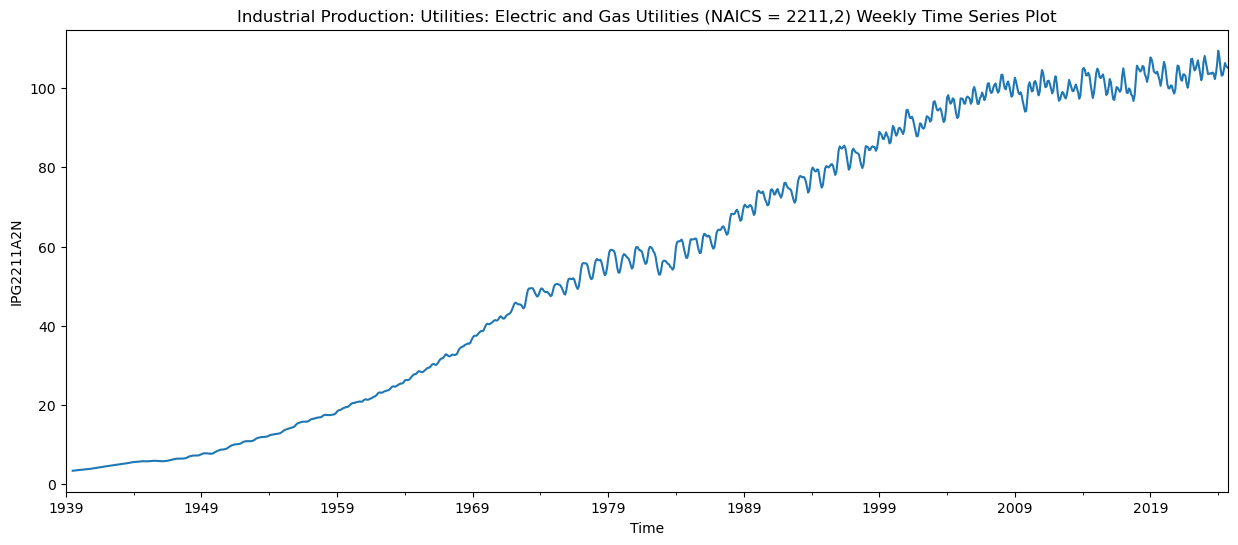

In [5]:
# 168 = number of hours per week
# Weekly rolling average plot
fig, ax = plt.subplots(figsize = (15, 6))
osho["IPG2211A2N"].rolling(7).mean().plot(
    xlabel = "Time",
    ylabel = "IPG2211A2N",
    title = "Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2) Weekly Time Series Plot",
    ax = ax
);

In [6]:
# Create a lag by 1 column
osho["IPG2211A2N.L1"] = osho["IPG2211A2N"].shift(1)
osho.dropna(inplace = True)

osho.head()

,IPG2211A2N,IPG2211A2N.L1
DATE,,
1939-02-01,3.3591,3.3336
1939-03-01,3.4354,3.3591
1939-04-01,3.4608,3.4354
1939-05-01,3.4608,3.4608
1939-06-01,3.5117,3.4608


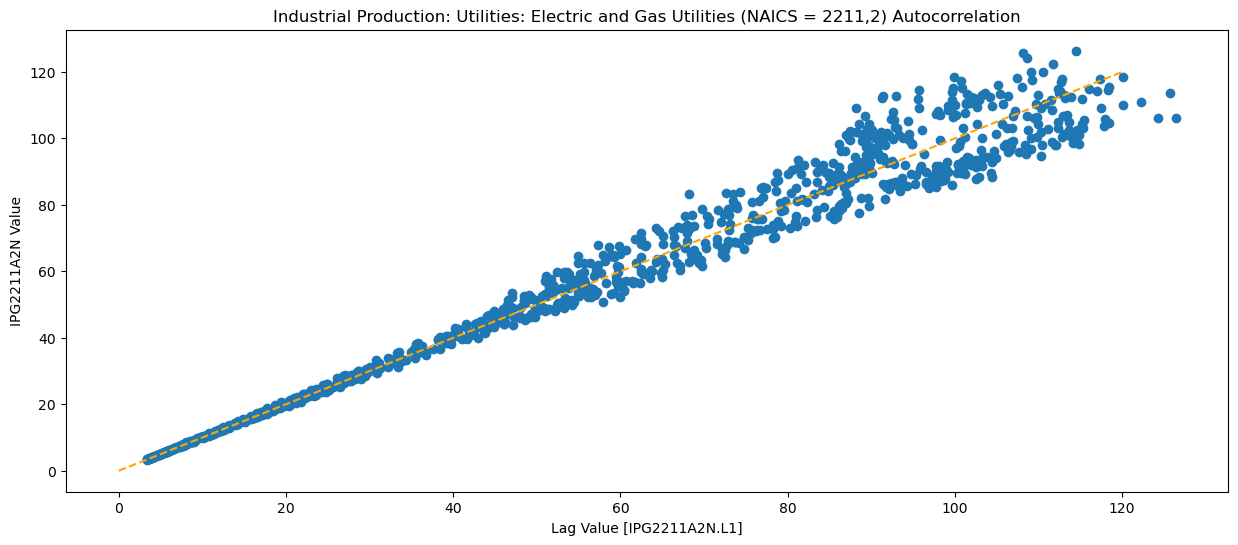

In [7]:
# Plot the correlation between the PM2.5 and PM2.5 by Lag 1 values
fig, ax = plt.subplots(figsize = (15, 6))
ax.scatter(
    x = osho["IPG2211A2N.L1"],
    y = osho["IPG2211A2N"]
)
plt.title("Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2) Autocorrelation")
plt.xlabel("Lag Value [IPG2211A2N.L1]")
plt.ylabel("IPG2211A2N Value")
ax.plot([0, 120], [0, 120], linestyle = "--", color = "orange");

In [8]:
# Split into training and test set
X = osho.drop(columns = "IPG2211A2N")
y = osho["IPG2211A2N"]
cutoff = int(len(X)*0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

# Ensure y_train has a datetime index with frequency
y_train = y_train.asfreq('MS')

In [9]:
# Train and Evaluate a Baseline Model
baseline_mae = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
baseline_mae = round(baseline_mae, 1)
print("The Benchmark of the model is:", baseline_mae)

The Benchmark of the model is: 27.1


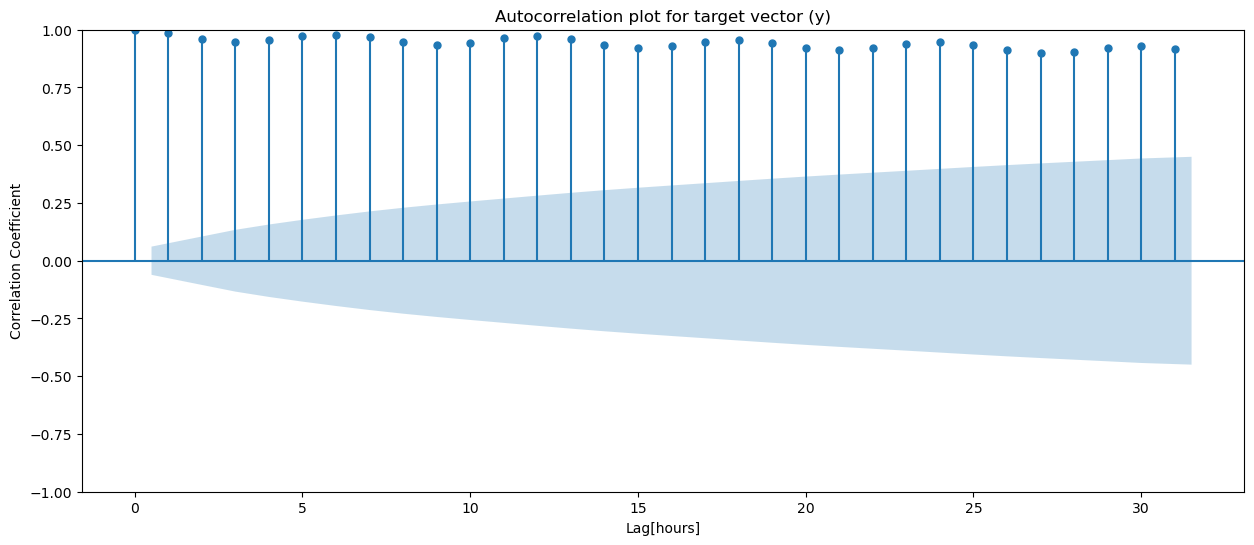

In [10]:
# Plot the ACF for the target values
fig, ax = plt.subplots(figsize = (15, 6))
plot_acf(y, ax =ax)
plt.xlabel("Lag[hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Autocorrelation plot for target vector (y)");

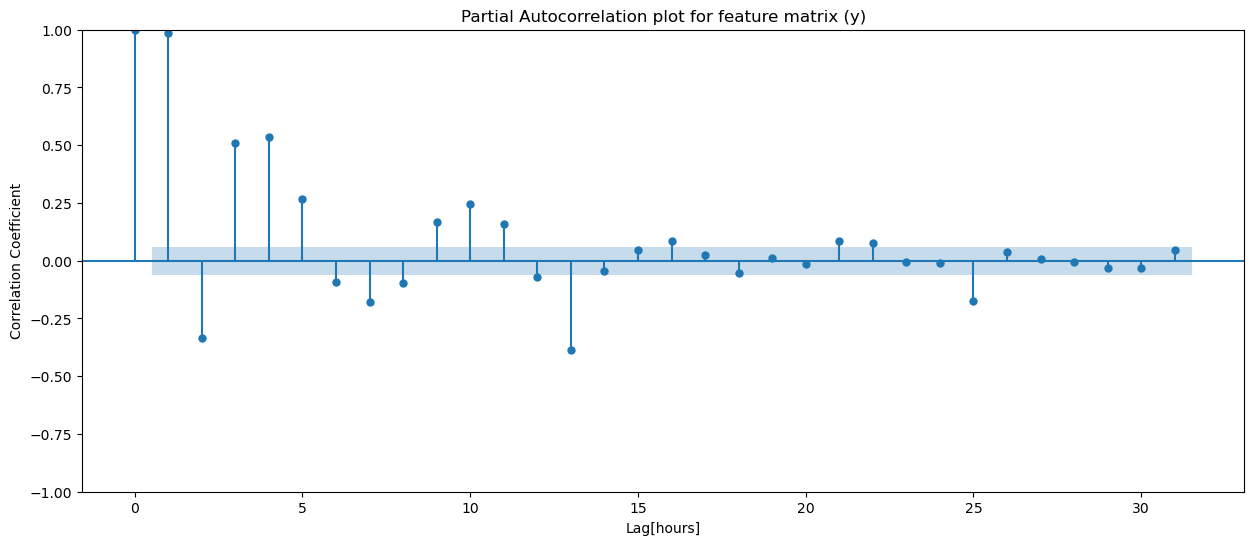

In [11]:
# Plot the PACF for the target values
fig, ax = plt.subplots(figsize = (15, 6))
plot_pacf(y, ax =ax)
plt.xlabel("Lag[hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Partial Autocorrelation plot for feature matrix (y)");

In [12]:
# Train an Auto Regressive Model.
autoReg_model = AutoReg(y_train, lags = 10).fit()

# Evaluate 
y_predReg = autoReg_model.predict().dropna()
autoReg_mae = mean_absolute_error(y_train.iloc[10:], y_predReg)
print("The mean absolute error of the Auto Regressive model is:", round(autoReg_mae, 1))
print("The Auto Regressive model outperform the Baseline Model with:", round(baseline_mae - autoReg_mae, 1))

The mean absolute error of the Auto Regressive model is: 1.3
The Auto Regressive model outperform the Baseline Model with: 25.8


In [13]:
# Save model for future use
with open("Industrial Production Predictive Model File.pkl", "wb") as f:
    pickle.dump(autoReg_model, f)

In [14]:
# Calculate residuals: the difference between actual and predicted values
y_train_resid = autoReg_model.resid
y_train_resid[:5]

DATE
1939-12-01   -0.200120
1940-01-01   -0.208434
1940-02-01   -0.203635
1940-03-01   -0.219541
1940-04-01   -0.258733
Freq: MS, dtype: float64

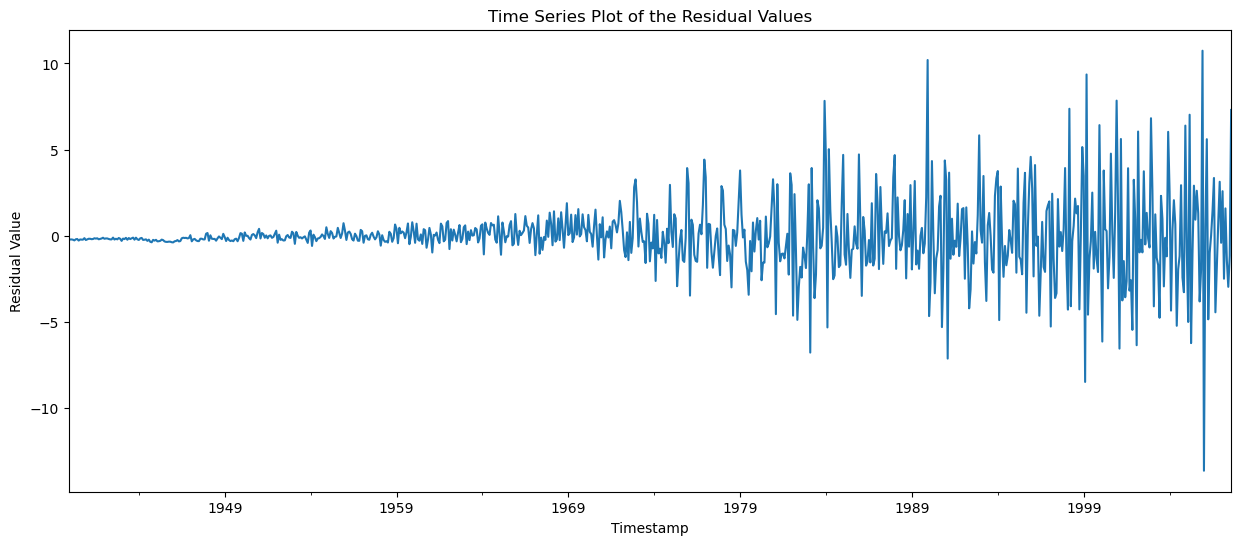

In [43]:
# Plot the residual values
fig, ax = plt.subplots(figsize = (15, 6))
y_train_resid.plot(
    xlabel = "Timestamp",
    ylabel = "Residual Value",
    title = "Time Series Plot of the Residual Values",
    ax = ax
);

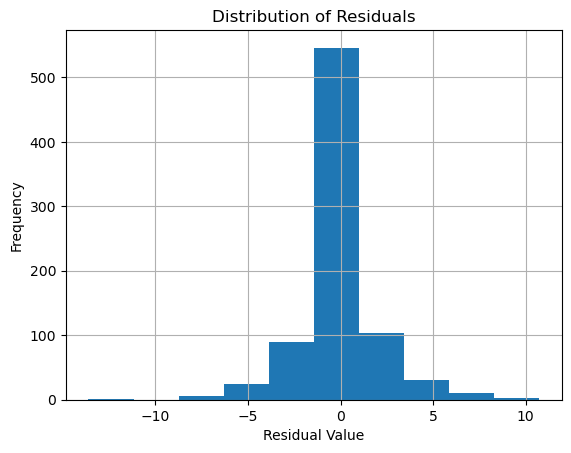

In [44]:
# Nominal Histogram of the residual values
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals");

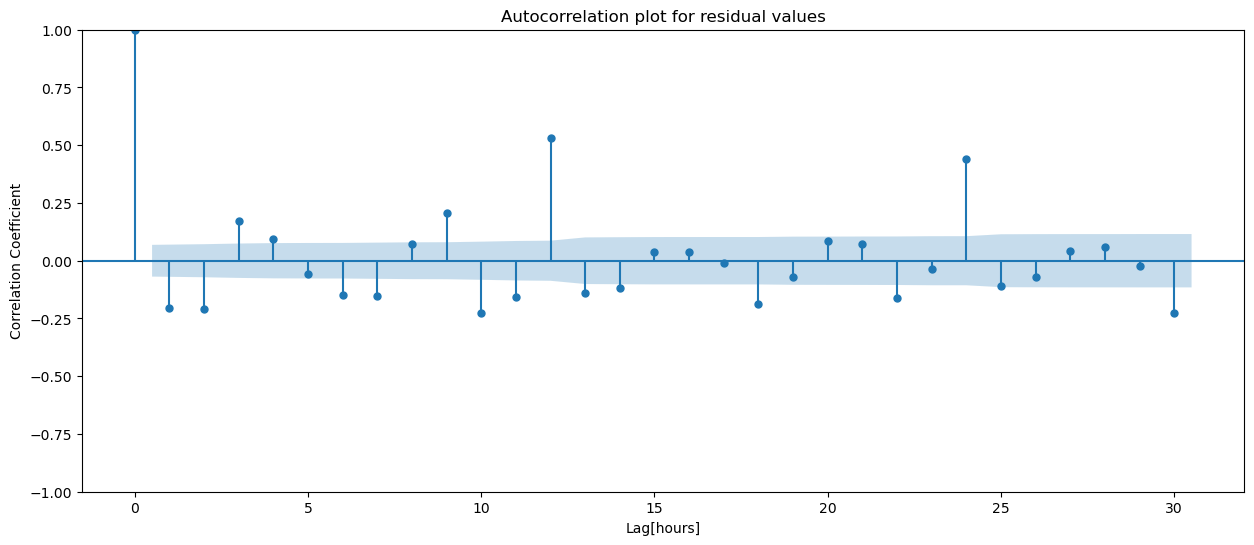

In [45]:
# ACF plot of the residual values
fig, ax = plt.subplots(figsize = (15, 6))
plot_acf(y_train_resid, ax =ax)
plt.xlabel("Lag[hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Autocorrelation plot for residual values");

In [14]:
# Making Predictions on the test set
y_pred_test = autoReg_model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_pred_test, y_test)
print("The mean absolute error of our test set is:", round(test_mae, 1))

The mean absolute error of our test set is: 17.5


In [47]:
# Test set predictions dataframe using Autoregression Model
df_test_mae = pd.DataFrame(
    {
        "y_test": y_test,
        "y_test_pred": y_pred_test
    }
)
df_test_mae.head()

,y_test,y_test_pred
2007-09-01,100.3374,104.806177
2007-10-01,91.8884,95.695362
2007-11-01,92.7412,95.493821
2007-12-01,105.4420,103.283446
2008-01-01,113.4467,110.353247


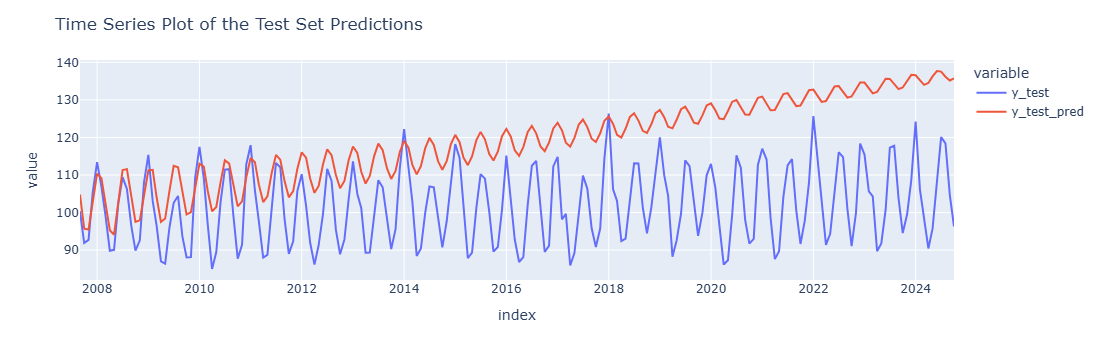

In [56]:
# Time series plot of the test set prediction
fig = px.line(
    df_test_mae,
    labels = {"Value": "IPG2211A2N"}
)
fig.update_layout(title = "Time Series Plot of the Test Set Predictions")
fig.show()

In [49]:
%%capture
# Initialize an empty Series with float type to save our future predictions
auto_wfv_test_pred = pd.Series(dtype=float)
# Copy the training target set as our past
past = y_train.copy()

# Iterate through the length of y_test
for i in range(len(y_test)):

    # Train the model
    model = AutoReg(past, lags=10).fit()

    # Make prediction
    next_pred = model.forecast()
    
    # Append prediction
    next_pred = pd.Series(next_pred, index=[y_test.index[i]])

    # Append to walk forwatd validation
    auto_wfv_test_pred = pd.concat([auto_wfv_test_pred, next_pred])
    past = pd.concat([past, pd.Series(y_test.iloc[i], index=[y_test.index[i]])])

# Calculate the mean absolute error for the list of predictions
test_mae = mean_absolute_error(y_test, auto_wfv_test_pred)
print("Test MAE (walk forward validation):", round(test_mae, 2))

In [50]:
# Create a data frame for our test set and the walk-forward validation test prediction
test_pred_df = pd.DataFrame({"y_test":y_test,
                             "wfv_test_pred":auto_wfv_test_pred})
test_pred_df.head()

,y_test,wfv_test_pred
2007-09-01,100.3374,104.806177
2007-10-01,91.8884,91.339620
2007-11-01,92.7412,93.170579
2007-12-01,105.4420,102.095888
2008-01-01,113.4467,113.704491


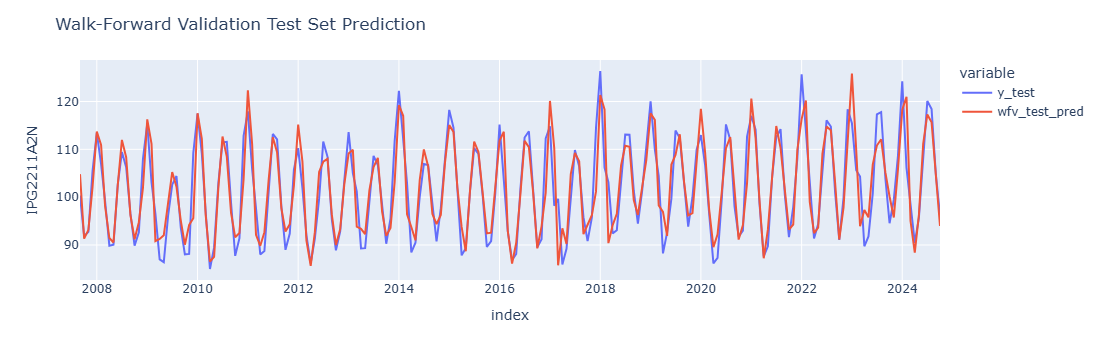

In [57]:
# Plot the test prediction data frame
fig = px.line(test_pred_df, labels={"value": "IPG2211A2N"})
fig.update_layout(title = "Walk-Forward Validation Test Set Prediction")
fig.show()

In [52]:
# Print out the parameters for our trained model
print(f"The parameters for our trained model are:\n{autoReg_model.params}")

The parameters for our trained model are:
const             0.306015
IPG2211A2N.L1     0.978694
IPG2211A2N.L2    -0.319259
IPG2211A2N.L3    -0.057051
IPG2211A2N.L4    -0.048222
IPG2211A2N.L5     0.214676
IPG2211A2N.L6     0.005098
IPG2211A2N.L7     0.149746
IPG2211A2N.L8    -0.196614
IPG2211A2N.L9    -0.141673
IPG2211A2N.L10    0.416956
dtype: float64


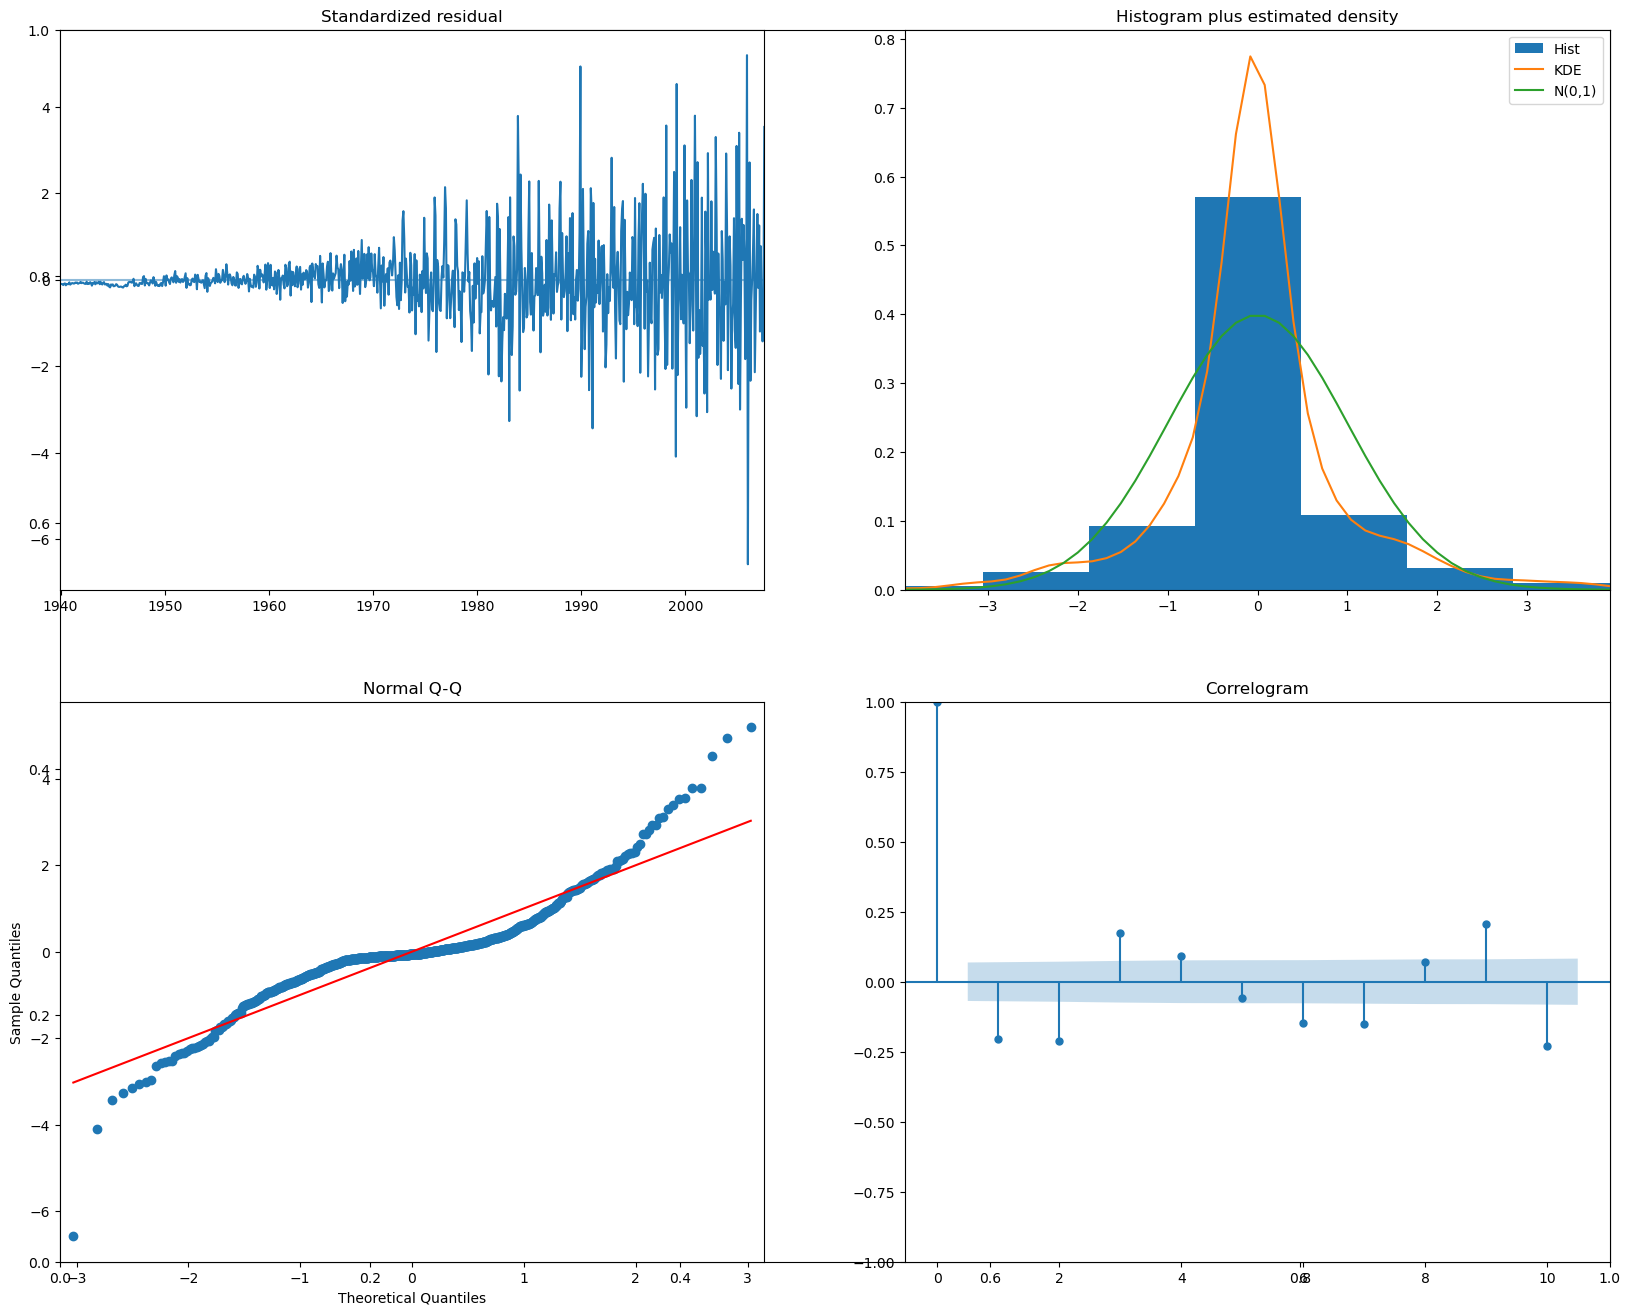

In [53]:
# Plot diagnostic to check the residuals of our model
fig, ax = plt.subplots(figsize=(20, 16))
autoReg_model.plot_diagnostics(fig = fig);